In [1]:
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from aurora import Aurora

model = Aurora()
# model.load_checkpoint("microsoft/aurora", "aurora-0.25-finetuned.ckpt")
model.load_checkpoint_local(
    "/Users/pmpaquet/Projects/Stanford/CS229S/Project/Project_aurora/models/hf_ckpt/aurora-0.25-finetuned.ckpt"
)

In [8]:
for module in model.modules():
    print(module)
    print()

Aurora(
  (encoder): Perceiver3DEncoder(
    (surf_mlp): MLP(
      (net): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=2048, out_features=512, bias=True)
        (3): Dropout(p=0.0, inplace=False)
      )
    )
    (surf_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (pos_embed): Linear(in_features=512, out_features=512, bias=True)
    (scale_embed): Linear(in_features=512, out_features=512, bias=True)
    (lead_time_embed): Linear(in_features=512, out_features=512, bias=True)
    (absolute_time_embed): Linear(in_features=512, out_features=512, bias=True)
    (atmos_levels_embed): Linear(in_features=512, out_features=512, bias=True)
    (surf_token_embeds): LevelPatchEmbed(
      (weights): ParameterDict(
          (10u): Parameter containing: [torch.FloatTensor of size 512x1x2x4x4]
          (10v): Parameter containing: [torch.FloatTensor of size 512x1x2x4x4]
    

# More systematic investigation

In [19]:
RESULTS_DICT = {}

def concat_neg(x: np.ndarray) -> np.ndarray:
    return np.concatenate((x, -1.*x), axis=0)

In [9]:
from aurora.model.decoder import Perceiver3DDecoder
from aurora.model.encoder import Perceiver3DEncoder
from aurora.model.swin3d import BasicLayer3D, Swin3DTransformerBackbone

In [10]:
encoder: Perceiver3DEncoder = model.encoder
backbone: Swin3DTransformerBackbone = model.backbone
decoder: Perceiver3DDecoder = model.decoder

## ENCODER

In [ ]:
from aurora.model.perceiver import MLP

# Learnable embedding to encode the surface level.
# self.surf_level_encoding = nn.Parameter(torch.randn(embed_dim))
# self.surf_mlp = MLP(embed_dim, int(embed_dim * mlp_ratio), dropout=drop_rate)
# self.surf_norm = nn.LayerNorm(embed_dim)

# # Position, scale, and time embeddings
# self.pos_embed = nn.Linear(embed_dim, embed_dim)
# self.scale_embed = nn.Linear(embed_dim, embed_dim)
# self.lead_time_embed = nn.Linear(embed_dim, embed_dim)
# self.absolute_time_embed = nn.Linear(embed_dim, embed_dim)
# self.atmos_levels_embed = nn.Linear(embed_dim, embed_dim)

surf_mlp: MLP = encoder.surf_mlp

Sequential(
  (0): Linear(in_features=512, out_features=2048, bias=True)
  (1): GELU(approximate='none')
  (2): Linear(in_features=2048, out_features=512, bias=True)
  (3): Dropout(p=0.0, inplace=False)
)
Linear(in_features=512, out_features=2048, bias=True)
GELU(approximate='none')
Linear(in_features=2048, out_features=512, bias=True)
Dropout(p=0.0, inplace=False)


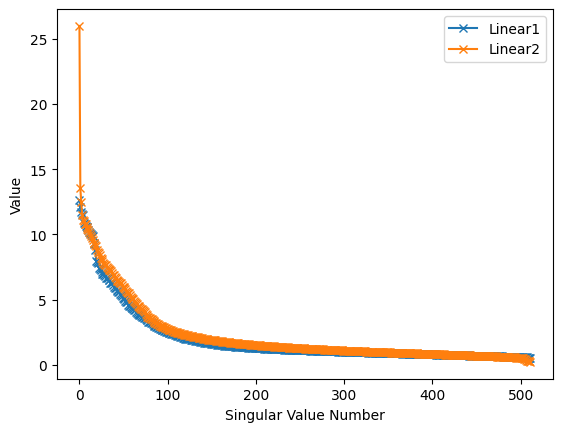

In [ ]:
i = 1
x = None
for module in surf_mlp.net.modules():
    print(module)
    if module._get_name() != 'Linear':
        continue
    u, s, vh = torch.linalg.svd(module.weight.detach())

    plt.plot(np.arange(s.numpy().shape[0]), s.numpy().reshape((-1,)), '-x', label=f'Linear{i}')
    i += 1

del i, u, s, vh, module
plt.xlabel('Singular Value Number')
plt.ylabel('Value')
plt.legend()
plt.show()
plt.close()


Sequential(
  (0): Linear(in_features=512, out_features=2048, bias=True)
  (1): GELU(approximate='none')
  (2): Linear(in_features=2048, out_features=512, bias=True)
  (3): Dropout(p=0.0, inplace=False)
)
Linear(in_features=512, out_features=2048, bias=True)
GELU(approximate='none')
Linear(in_features=2048, out_features=512, bias=True)
Dropout(p=0.0, inplace=False)


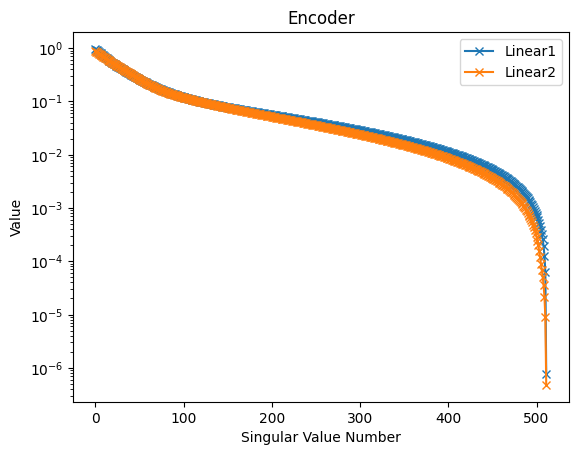

In [27]:
i = 1
for module in surf_mlp.net.modules():
    print(module)
    if module._get_name() != 'Linear':
        continue
    x = module.weight.detach().numpy()
    if x.shape[0] < x.shape[1]:
        x = x.T
    pca = PCA()
    # pca.fit(concat_neg(x))
    pca.fit(concat_neg(x))

    # plt.plot(np.arange(pca.n_components_), pca.singular_values_, '-x', label=f'Linear{i}')
    plt.plot(np.arange(pca.n_components_), 1.-np.cumsum(pca.explained_variance_ratio_), '-x', label=f'Linear{i}')
    i += 1

del x, pca, i
plt.xlabel('Singular Value Number')
plt.ylabel('Value')
plt.yscale('log')
plt.legend()
plt.title('Encoder')
plt.show()
plt.close()


## DECODER

In [ ]:
# SKIP FOR NOW

## BACKBONE

In [16]:
print('Number of encoder layers:', len(backbone.encoder_layers))
print('Number of decoder layers:', len(backbone.decoder_layers))

Number of encoder layers: 3
Number of decoder layers: 3


In [17]:
from aurora.model.swin3d import Basic3DDecoderLayer, Basic3DEncoderLayer, BasicLayer3D
from aurora.model.swin3d import Swin3DTransformerBlock

In [25]:
for i,enc in enumerate(backbone.encoder_layers):
    print(f'Encoder layer {i}: {len(enc.blocks)} blocks')
del i, enc
print()
for i,dec in enumerate(backbone.decoder_layers):
    print(f'Decoder layer {i}: {len(dec.blocks)} blocks')
del i, dec

Encoder layer 0: 6 blocks
Encoder layer 1: 10 blocks
Encoder layer 2: 8 blocks

Decoder layer 0: 8 blocks
Decoder layer 1: 10 blocks
Decoder layer 2: 6 blocks


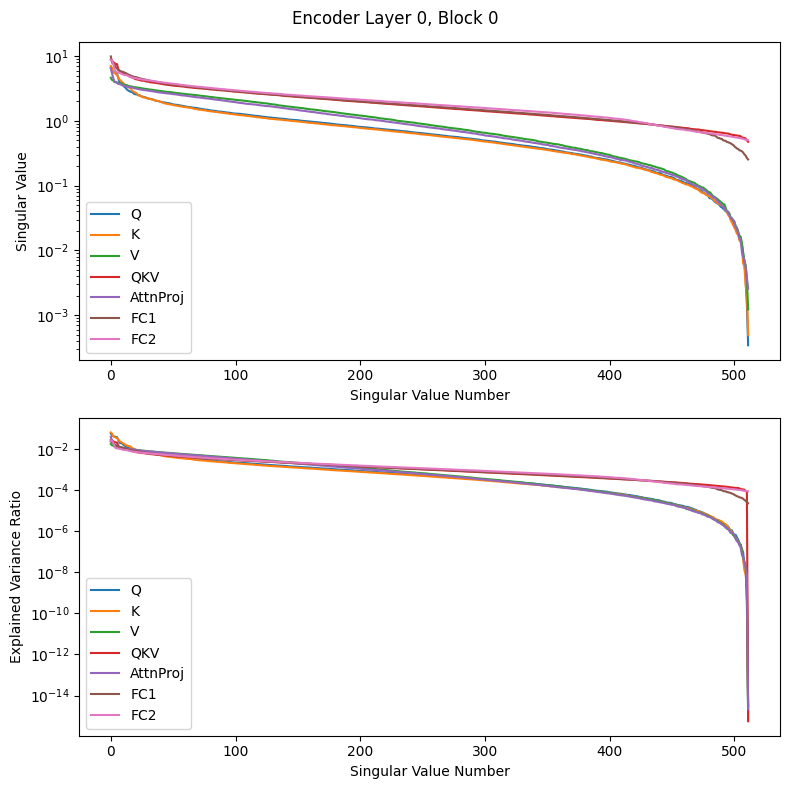

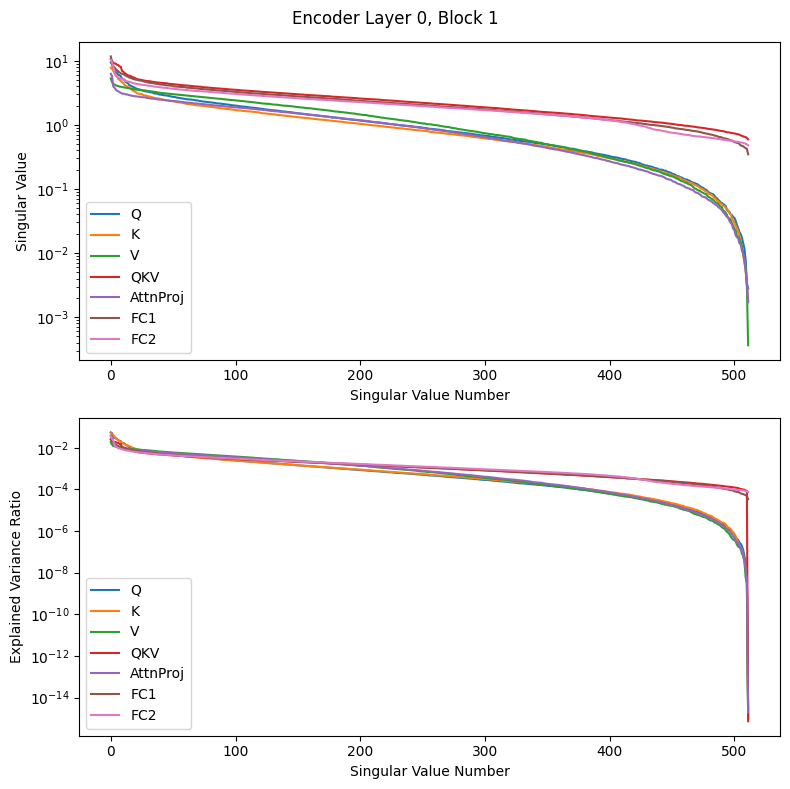

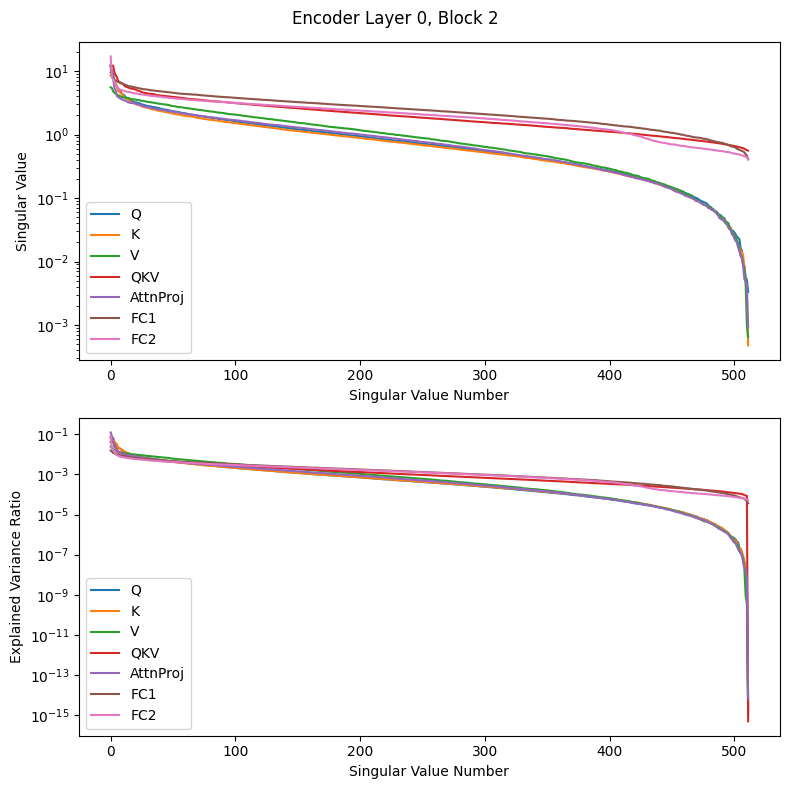

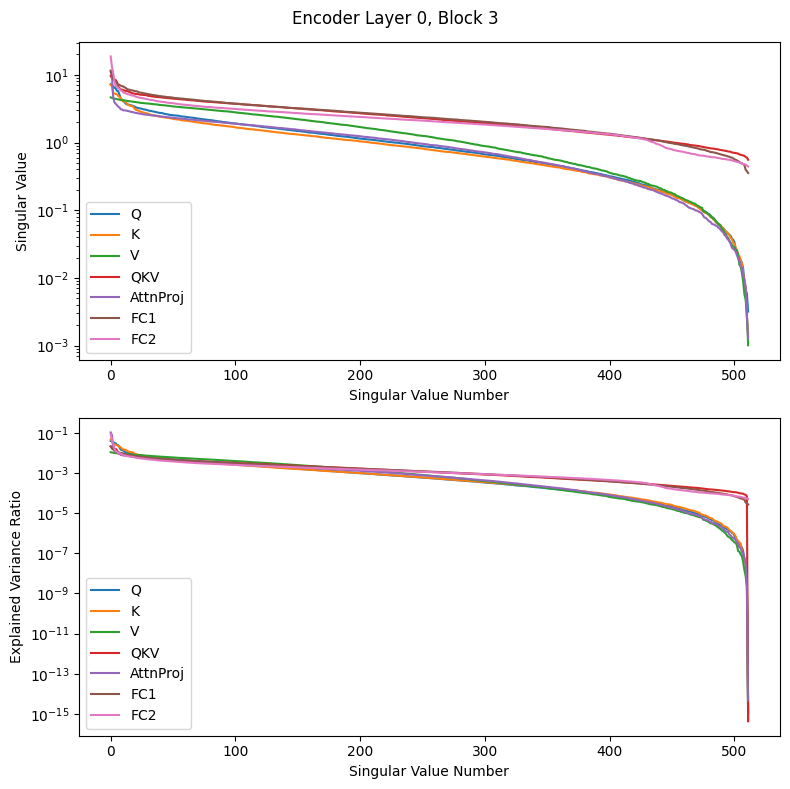

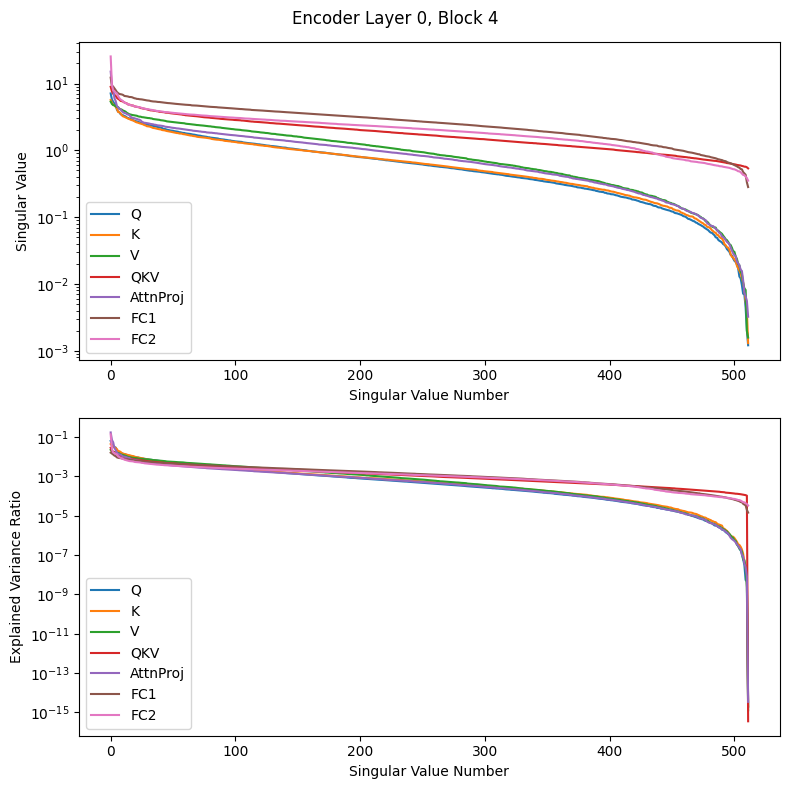

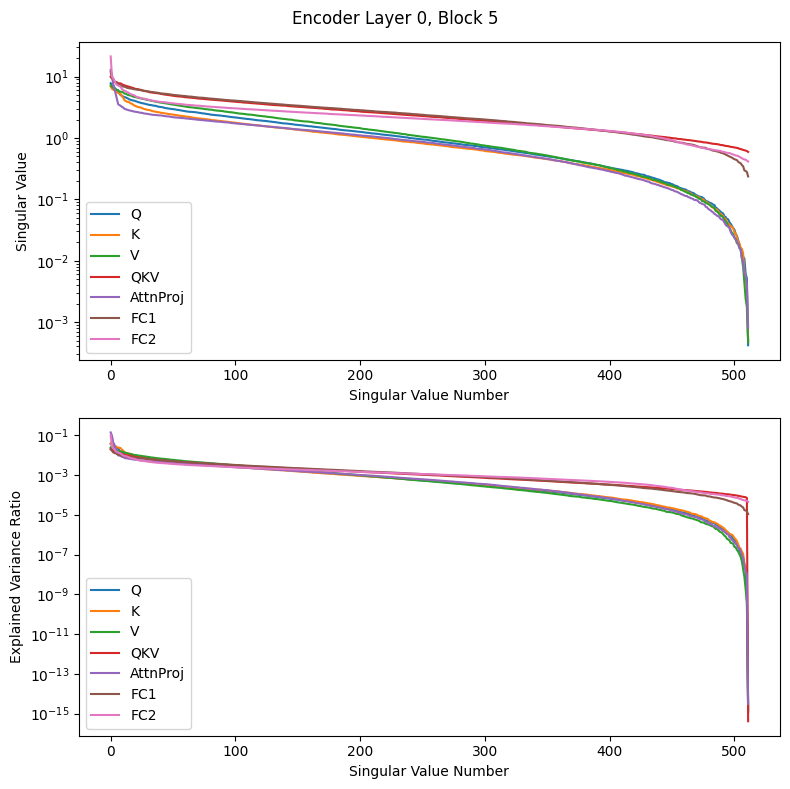

KeyboardInterrupt: 

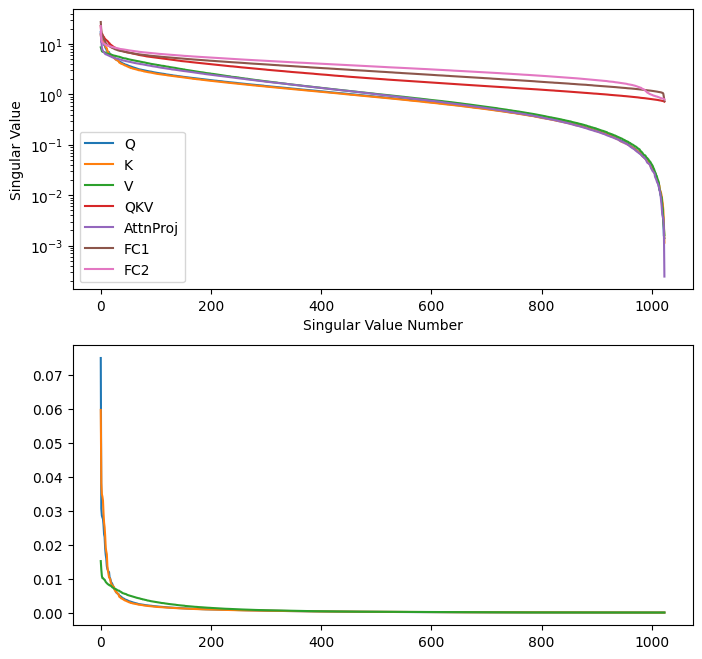

In [34]:
for i,enc in enumerate(backbone.encoder_layers):
    
    for bi,block in enumerate(enc.blocks):
        fig, axes = plt.subplots(nrows=2, ncols=1, facecolor='white', figsize=(8,8))
        # print(block.attn.qkv.weight.shape)
        axes[0].plot(np.arange(int(block.dim)), torch.linalg.svdvals(block.attn.qkv.weight.detach()[:block.dim]).numpy().reshape((-1,)), label='Q')
        axes[0].plot(np.arange(int(block.dim)), torch.linalg.svdvals(block.attn.qkv.weight.detach()[block.dim:(2*block.dim)]).numpy().reshape((-1,)), label='K')
        axes[0].plot(np.arange(int(block.dim)), torch.linalg.svdvals(block.attn.qkv.weight.detach()[2*block.dim:]).numpy().reshape((-1,)), label='V')
        axes[0].plot(np.arange(int(block.dim)), torch.linalg.svdvals(block.attn.qkv.weight.detach().T).numpy().reshape((-1,))[:block.dim], label='QKV')
        axes[0].plot(np.arange(int(block.dim)), torch.linalg.svdvals(block.attn.proj.weight.detach()).numpy().reshape((-1,)), label='AttnProj')
        
        axes[0].plot(np.arange(int(block.dim)), torch.linalg.svdvals(block.mlp.fc1.weight.detach()).numpy().reshape((-1,)), label=f'FC1')
        axes[0].plot(np.arange(int(block.dim)), torch.linalg.svdvals(block.mlp.fc2.weight.detach()).numpy().reshape((-1,)), label=f'FC2')

        axes[0].set_xlabel('Singular Value Number')
        axes[0].set_ylabel('Singular Value')
        axes[0].set_yscale('log')
        axes[0].legend()

        pca = PCA(block.dim)
        pca.fit(block.attn.qkv.weight.detach()[:block.dim].numpy())
        axes[1].plot(np.arange(int(block.dim)), pca.explained_variance_ratio_, label='Q')
        pca.fit(block.attn.qkv.weight.detach()[block.dim:(2*block.dim)].numpy())
        axes[1].plot(np.arange(int(block.dim)), pca.explained_variance_ratio_, label='K')
        pca.fit(block.attn.qkv.weight.detach()[2*block.dim:].numpy())
        axes[1].plot(np.arange(int(block.dim)), pca.explained_variance_ratio_, label='V')
        pca.fit(block.attn.qkv.weight.detach().numpy().T)
        axes[1].plot(np.arange(int(block.dim)), pca.explained_variance_ratio_, label='QKV')
        pca.fit(block.attn.proj.weight.detach().numpy())
        axes[1].plot(np.arange(int(block.dim)), pca.explained_variance_ratio_, label='AttnProj')
        
        x = block.mlp.fc1.weight.detach().numpy()
        if x.shape[0] < x.shape[1]:
            x = x.T
        pca.fit(x)
        axes[1].plot(np.arange(int(block.dim)), pca.explained_variance_ratio_, label=f'FC1')
        x = block.mlp.fc2.weight.detach().numpy()
        if x.shape[0] < x.shape[1]:
            x = x.T
        pca.fit(x)
        axes[1].plot(np.arange(int(block.dim)), pca.explained_variance_ratio_, label=f'FC2')
        del x, pca

        axes[1].set_xlabel('Singular Value Number')
        axes[1].set_ylabel('Explained Variance Ratio')
        axes[1].set_yscale('log')
        axes[1].legend()

        fig.suptitle(f'Encoder Layer {i}, Block {bi}')
        fig.tight_layout()
        plt.show()
        plt.close()
        del fig, axes